**Introduction**

**Problem Statement**:
In this dataset we have to predict the sales price of  houses in King County, Seattle. 

Before doing anything we should first know about the dataset what it contains what are its features and what is the structure of data.It includes homes sold between May 2014 and May 2015.

The dataset cantains **20** house features plus the price, along with **21613** observations.

The description for the 20 features is given below: <br>

**1. id** :- It is the unique numeric  number assigned to each house being sold. <br>
**2. date** :- It is the date on which the house was sold out. <br>
**3. price**:- It is the price of house which we have to predict so this is our target variable and aprat from it are our features. <br>
**4. bedrooms** :- It determines number of bedrooms in a house. <br>
**5. bathrooms** :- It determines number of bathrooms in a bedroom of a house. <br>
**6.  sqft_living** :- It is the measurement variable which determines the measurement of house in square foot. <br>
**7. sqft_lot** : It is also the measurement variable which determines  square foot of the lot. <br>
**8. floors**: It determines total floors means levels of house. <br>
**9. waterfront** : This feature determines whether a house has a view to waterfront 0 means no 1 means yes. <br>
**10. view** : This feature determines whether a house has been viewed or not  0 means no 1 means yes. <br>
**11. condition** : It determines the overall condition of a house on a scale of 1 to 5. <br>
**12. grade** : It determines the overall grade given to the housing unit, based on King County grading system on a scale of 1 to 11. <br>
**13. sqft_above** : It determines square footage of house apart from basement. <br>
**14. sqft_basement** : It determines square footage of the basement of the house. <br>
**15. yr_built** : It detrmines the date of building of the house. <br>
**16. yr_renovated** : It detrmines year of renovation of house. <br>
**17. zipcode**  : It determines the zipcode of the location of the house. <br>
**18. lat** : It determines the latitude of the location of the house. <br>
**19.  long** : It determines the longitude of the location of the house. <br>
**20. sqft_living15** : Living room area in 2015(implies-- some renovations)  <br>
**21. sqft_lot15** : lotSize area in 2015(implies-- some renovations) <br>

In [45]:
# Importing Libraries
import numpy as np
import pandas as pd
import xgboost
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from time import time
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm 
from sklearn.metrics import mean_absolute_error

In [5]:
data = pd.read_csv('kc_house_data.csv')

In [7]:
# Copying data to another dataframe df_train for our convinience so that original dataframe remain intact.

df_train=data.copy()
df_train.rename(columns ={'price': 'SalePrice'}, inplace =True)


In [9]:
# Now lets see the first five rows of the data
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


**DATA CLEANING AND PREPROCESSING**

In this step we check whether data contain null or missing values. What is the size of the data. What is the datatype of each column. What are unique values of categorical variables etc.

In [13]:
print(data.shape) # shape 
# Check the data types of each column
print(data.dtypes)

(21613, 21)
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


In [18]:
data.nunique()

id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
dtype: int64

In [14]:
# Check any number of columns with NaN or missing values 
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21613


**FINDING CORRELATION**

In this step we check by finding correlation of all the features wrt target variable i.e., price to see whether they are positively correlated or negatively correlated to find if they help in prediction process in model building process or not. But this is also one of the most important step as it also involves domain knowledge of the field of the data means you cannot simply remove the feature from your prediction process just because it is negatively correlated because it may contribute in future prediction for this you should take help of some domain knowledge personnel.

In [15]:
# As id and date columns are not important to predict price so we are discarding it for finding correlation
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [16]:
# Finding Correlation of price woth other variables to see how many variables are strongly correlated with price
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [17]:
# Printing all the correlated features value with respect to price which is target variable
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


As zipcode is negatively correlated with sales price , so we can discard it for sales price prediction.

**EDA or DATA VISUALIZATION**

This is also a very important step in your prediction process as it help you to get aware you about existing patterns in the data how it is relating to your target variables etc.

<Figure size 864x576 with 0 Axes>

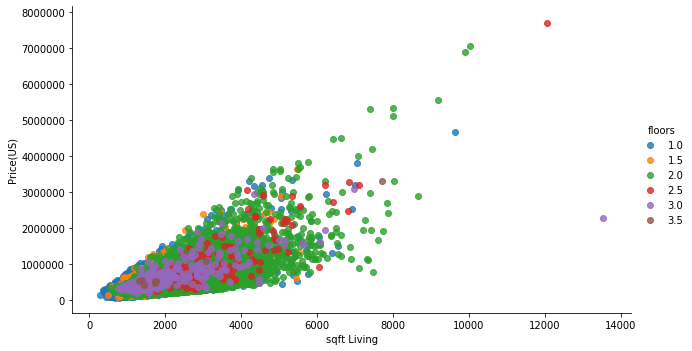

In [19]:
plt.figure(figsize = (12,8))
plot_p = sns.lmplot(x="sqft_living", y="price", aspect=1.8,data=data, hue="floors", fit_reg=False)
plot_p.set_titles("Floors by sqft_living and price", fontsize=15)
plot_p.set_xlabels("sqft Living")
plot_p.set_ylabels("Price(US)")
plt.show()

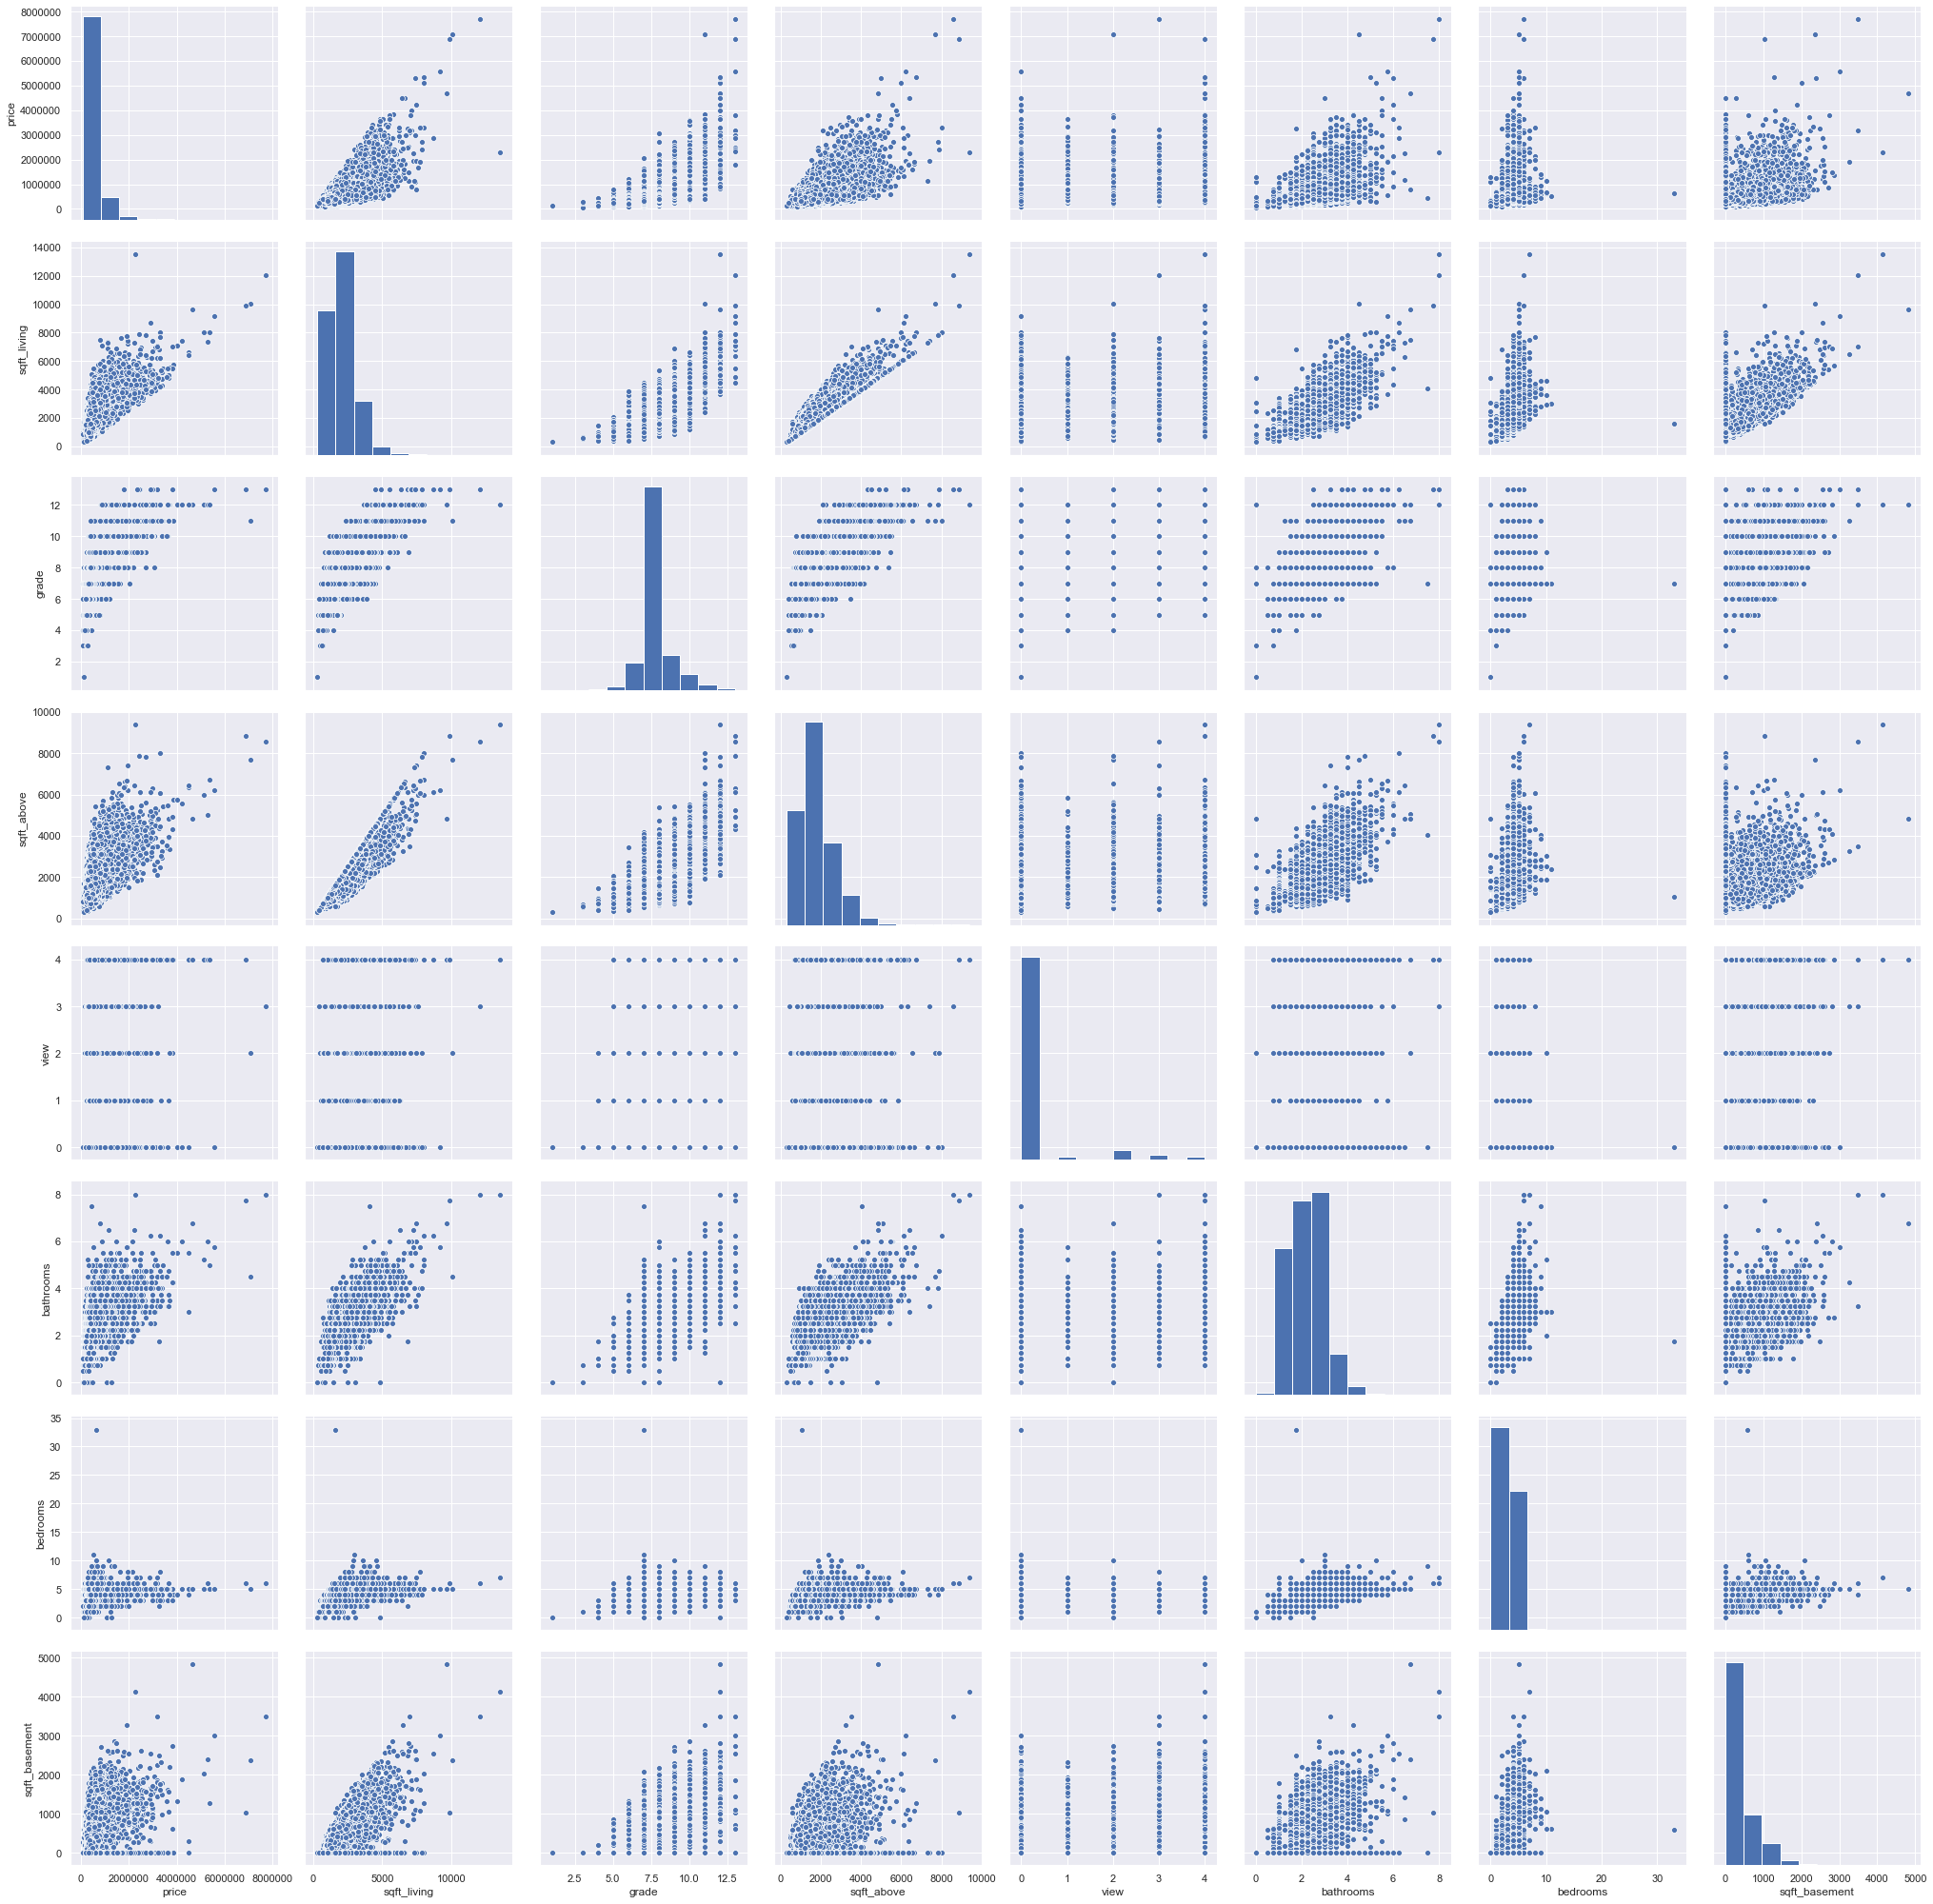

In [24]:
#Pairplots to visualize strong correlation
sns.set()
cols = [ 'price','sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms','bedrooms','sqft_basement']
sns.pairplot(data[cols], height = 3.5)
plt.show();

Text(0, 0.5, 'saleprice')

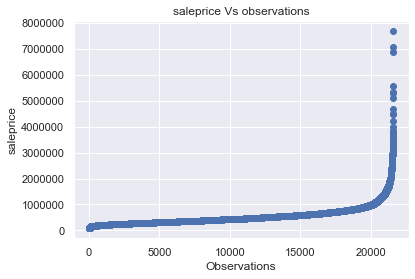

In [27]:
saleprice = data["price"].values
plt.scatter(x = range(saleprice.shape[0]), y = np.sort(saleprice))
plt.title('saleprice Vs observations')
plt.xlabel('Observations')
plt.ylabel('saleprice')

13


Text(0, 0.5, 'Houses Count')

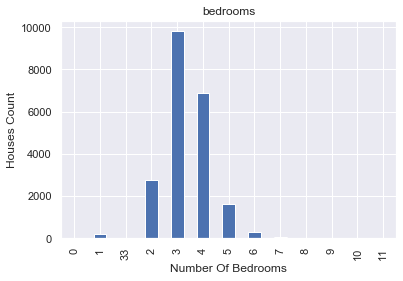

In [28]:
print(data["bedrooms"].unique().shape[0])
data["bedrooms"].value_counts(sort = False).plot.bar()
plt.title("bedrooms")
plt.xlabel("Number Of Bedrooms")
plt.ylabel("Houses Count")

12


Text(0, 0.5, 'Houses Count')

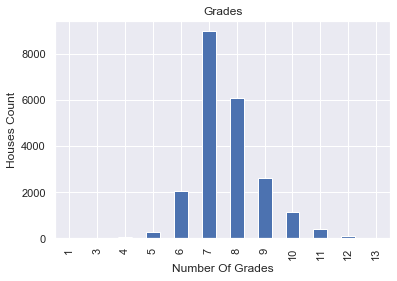

In [35]:
print(data["grade"].unique().shape[0])
data["grade"].value_counts(sort = False).plot.bar()
plt.title("Grades")
plt.xlabel("Number Of Grades")
plt.ylabel("Houses Count")

5


Text(0, 0.5, 'Houses Count')

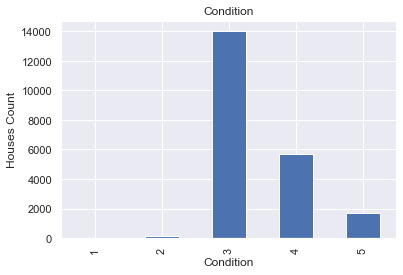

In [37]:

print(data["condition"].unique().shape[0])
data["condition"].value_counts(sort = False).plot.bar()
plt.title("Condition")
plt.xlabel("Condition")
plt.ylabel("Houses Count")

In [39]:
new_data = df_train[['sqft_living','grade', 'sqft_above', 
                     'sqft_living15','bathrooms','view','sqft_basement','waterfront','yr_built','lat','bedrooms','long']]
X = new_data.values
y = df_train.SalePrice.values

**SPLITTING DATA INTO TRAINING AND TESTING SET**

The training dataset and test dataset must be similar, usually have the same predictors or variables. They differ on the observations and specific values in the variables. If you fit the model on the training dataset, then you implicitly minimize error or find correct responses. The fitted model provides a good prediction on the training dataset. Then you test the model on the test dataset. If the model predicts good also on the test dataset, you have more confidence. You have more confidence since the test dataset is similar to the training dataset, but not the same nor seen by the model. It means the model transfers prediction or learning in real sense.So,by splitting dataset into training and testing subset, we can efficiently measure our trained model since it never sees testing data before.Thus it's possible to prevent overfitting.

I am just splitting dataset into 20% of test data and remaining 80% will used for training the model.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE


In [44]:
#splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=568)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17290, 12)
(4323, 12)
(17290,)
(4323,)


**Random Forest**

In [49]:
rand_regr = RandomForestRegressor(n_estimators=400,random_state=0)
rand_regr.fit(X_train, y_train)
print(rand_regr.score(X_test,y_test))
predictions = rand_regr.predict(X_test)

0.8795542542573592


In [51]:
from sklearn.metrics import explained_variance_score
explained_variance_score(predictions,y_test)

0.8605835146013804

**Decision Tree**

In [53]:
decision=DecisionTreeRegressor()
decision.fit(X_train, y_train)
print(decision.score(X_test,y_test))
prediction2 = decision.predict(X_test)

0.7531308516794722


In [54]:
explained_variance_score(prediction2,y_test)

0.7462570905933036

**AdaBoost**

In [58]:
ada=AdaBoostRegressor(n_estimators=50, learning_rate=0.2,loss='exponential').fit(X_train, y_train)
print(ada.score(X_test,y_test))
prediction3=ada.predict(X_test)

0.6118230119468999


In [60]:
explained_variance_score(prediction3,y_test)

0.4252569046678961

**GradientBoost**

In [63]:
Gdt=GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='ls',min_samples_split=2,
                              learning_rate=0.1).fit(X_train, y_train)
print(Gdt.score(X_test,y_test))

prediction4 = Gdt.predict(X_test)

0.8873309716191954


In [64]:
explained_variance_score(prediction4,y_test)

0.8767772560462372

**XGBoost**

In [69]:
XGB = XGBRegressor(n_estimators=100, learning_rate=0.09, gamma=0).fit(X_train, y_train)
print(XGB.score(X_test,y_test))
prediction5 = XGB.predict(X_test)

[12:54:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8489390145095123


In [70]:
explained_variance_score(prediction5,y_test)

0.8138353749256247

# **Conclusion**

So, we have seen that accuracy of gradient boosting is around 88.7% and also achieved decent variance score of 0.87 which is very close to 1 . Therefore, it is inferred that Gradient Boosting is the suitable model for this dataset.